# The Game is On!Part 2: Double Deep Q-Network (DDQN)
#### First, I have to give the proper credit to ***Udacity*** for making their ***Reinforcement Learning Nanodegree*** files open source in github. I used many of their codes


Following up from article on [DQN](https://sezan92.github.io/2020/03/18/DQN.html). It is mandatory to read that one first!

### Index

- [Background](#background)
- [ReplayBuffer](#replaybuffer)
- [QNetwork](#qnetwork)
- [Agent](#agent)
- [Compare](#compare)

<a id="background"></a>
### Background

Let's look at Bellman update equation again

\begin{equation}
\theta_Q \gets \theta_Q - \alpha \frac{\partial}{\partial \theta}(r+ \gamma max_a(Q_{\theta}(s_{t+1},a))-Q_{\theta}(s_t,a))^2
\end{equation}

With target network $Q`_{\theta}$ , the equation becomes
\begin{equation}
\theta_Q \gets \theta_Q - \alpha \frac{\partial}{\partial \theta}(r+ \gamma max_a(Q`_{\theta}(s_{t+1},a))-Q_{\theta}(s_t,a))^2
\end{equation}

What we are doing in the update equation, the target is set according to the maximum action of target network ```qnetwork_target```. This is a bit problematic. We are not using target network's actions in the game! we are using local networks actions. So it is counter intuitive to update the action according to target network! We should fix the target of local network!

\begin{equation}
\theta_Q \gets \theta_Q - \alpha \frac{\partial}{\partial \theta}(r+ \gamma (Q`_{\theta}(s_{t+1},argmax_aQ_{\theta}(s_{t+1},a))-Q_{\theta}(s_t,a))^2
\end{equation}

Enough of Background, lets start coding!

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

initialize the environment

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


/floyd/home/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
state_shape= env.observation_space.shape[0]
action_size= env.action_space.n

<a id="qnetwork"></a>
### QNetwork Class

As usual, ***QNetwork*** class, nothing changed from DQN blog!

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=150, fc2_units=120):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.final = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.final(x)

<a id="replaybuffer"></a>
### ReplayBuffer

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

<a id = "agent"></a>
### Agent

I changed a little bit in the ```Agent``` class. The change is discussed in the following section

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.01              # for soft update of target parameters
LR = 0.001               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.criterion=nn.MSELoss()
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        predicted_actions=torch.argmax(self.qnetwork_local(next_states),1)
        predicted_actions=predicted_actions.reshape(-1,1)
      
        maxQ=self.qnetwork_target(next_states).gather(1,predicted_actions)
        y=rewards+gamma*maxQ*(1-dones)

        loss=F.mse_loss(y,self.qnetwork_local(states).gather(1,actions))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

#### The change in the ```agent``` class

We dont need to read full code! I have changed line 79 according to the equation in [background](#background) section

In [8]:

agent = Agent(state_size=state_shape, action_size=action_size, seed=0)

### Training!

In [9]:
n_episodes=1000
max_t=1000
eps_start=1.0
eps_end=0.1
eps_decay=0.995

In [11]:
def train_agent(agent,env,target_folder,eps_start=eps_start,eps_decay=eps_decay,eps_end=eps_end,gamma=GAMMA,n_episodes=n_episodes,max_t=max_t):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):

        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)

            agent.step(state, action, reward, next_state,done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode%10==0:
            torch.save(agent.qnetwork_local.state_dict(),"{}/dqn_agent{}.pkl".format(target_folder,i_episode))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
    return scores

In [13]:
scores_ddqn=train_agent(agent,env,target_folder="double_dqn/")

Episode 100	Average Score: -141.10
Episode 200	Average Score: -39.10
Episode 300	Average Score: 30.98
Episode 400	Average Score: 174.96
Episode 422	Average Score: 200.26
Environment solved in 322 episodes!	Average Score: 200.26
Episode 423	Average Score: 201.46
Environment solved in 323 episodes!	Average Score: 201.46
Episode 424	Average Score: 200.73
Environment solved in 324 episodes!	Average Score: 200.73
Episode 425	Average Score: 201.70
Environment solved in 325 episodes!	Average Score: 201.70
Episode 426	Average Score: 202.82
Environment solved in 326 episodes!	Average Score: 202.82
Episode 427	Average Score: 203.66
Environment solved in 327 episodes!	Average Score: 203.66
Episode 428	Average Score: 204.85
Environment solved in 328 episodes!	Average Score: 204.85
Episode 429	Average Score: 205.76
Environment solved in 329 episodes!	Average Score: 205.76
Episode 430	Average Score: 205.22
Environment solved in 330 episodes!	Average Score: 205.22
Episode 431	Average Score: 207.68
En

In [24]:
scores_ddqn_np = np.array(scores_ddqn)
np.savetxt("double_dqn/scores.txt",scores_ddqn_np)

In [14]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [16]:
scores_ma_ddqn=moving_average(scores_ddqn,n=100)

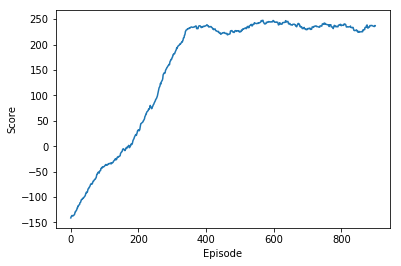

In [25]:
# plot the scores
plt.plot(np.arange(len(scores_ma_ddqn)), scores_ma_ddqn)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

<a id="compare"></a>
### Let's compare with the DQN? 

In [19]:
scores_dqn_with_target=np.loadtxt("dqn_with_target/scores.txt")
scores_dqn_no_target=np.loadtxt("dqn_no_target/scores.txt")

In [21]:
scores_ma_dqn_no_target=moving_average(scores_dqn_no_target,n=100)
scores_ma_dqn_with_target=moving_average(scores_dqn_with_target,n=100)


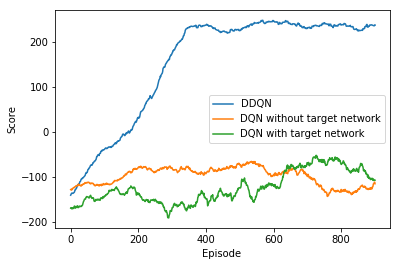

In [23]:
# plot the scores
plt.plot(np.arange(len(scores_ma_ddqn)), scores_ma_ddqn,label="DDQN")
plt.plot(np.arange(len(scores_ma_dqn_no_target)), scores_ma_dqn_no_target,label="DQN without target network")
plt.plot(np.arange(len(scores_ma_dqn_with_target)), scores_ma_dqn_with_target,label="DQN with target network")
plt.ylabel('Score')
plt.xlabel('Episode ')
plt.legend()

We see, Double Deep Q Network outscores other two!!! But is there still a place to improve?!! Obviously! Next blog comes on ***Duelling Double Deep Q Network!***